<a href="https://colab.research.google.com/github/pw0lf/2023-RSE_in_Julia/blob/main/Mnist_rotated/arch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.ndimage import rotate
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu, max_pool2d
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
!pip install topomodelx
!pip install toponetx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 62.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 require

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C


In [3]:
import toponetx as tnx
from toponetx.classes import CombinatorialComplex
from topomodelx.utils.sparse import from_sparse
from itertools import product

In [4]:
full_dataset = datasets.MNIST(root="Masterarbeit/data", train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 620kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.62MB/s]


In [5]:
full_dataset.targets.size()[0]

60000

In [6]:
def rotate_batch(images, angle):
    rotated = np.array([rotate(img.squeeze(),angle,reshape=False, mode='nearest') for img in images])
    return torch.tensor(rotated).unsqueeze(1).float()

def get_mnist_rot(angle, subset=None, batch_size=64, shuffle=False ,train=False):
    full_dataset = datasets.MNIST(root="Masterarbeit/data", train=train, download=True, transform=transforms.ToTensor())

    x_full = full_dataset.data.numpy() / 255.0
    y_full = full_dataset.targets.numpy()

    if subset is not None:
        full_samples = full_dataset.targets.size()[0]
        subset = np.random.choice(full_samples, subset, replace=False)
        x = x_full[list(subset)]
        y = y_full[list(subset)]
    else:
        x = x_full
        y = y_full

    x_rot = rotate_batch(x, angle)

    y_tensor = torch.tensor(y, dtype=torch.long)

    rotated_dataset = TensorDataset(x_rot, y_tensor)
    rotated_loader = DataLoader(rotated_dataset, batch_size=batch_size, shuffle=shuffle)
    return rotated_loader

In [7]:
def create_combinatorial_complex(rows,cols):
    CC = CombinatorialComplex()

    # Add 0-cells:
    for i,j in product(range(rows),range(cols)):
        node_id = i * cols + j
        CC.add_cell(node_id, rank=0)

    #Add 1-cells (first convolution 2x2 faces)
    for i,j in product(range(rows),range(cols)):
        node_id = i * cols + j
        if (j < cols-1) and (i < rows-1):
            CC.add_cell((node_id,node_id+1,node_id+cols,node_id+cols+1),rank=1)

    # Add 2-cells (second convolution 2x2 faces) TODO: Wrong 2-cells; not equvialent to other convnet
    for i,j in product(range(rows),range(cols)):
        node_id = i * cols + j
        if (j < cols-2) and (j > 0) and (i > 0) and (i < rows -2):
            CC.add_cell((node_id-cols,node_id-cols+1
                        ,node_id-1,node_id,node_id+1,node_id+2,
                        node_id+cols-1,node_id+cols,node_id+cols+1,node_id+cols+2,
                        node_id+2*cols,node_id+2*cols+1),rank=2)

    return CC

In [8]:
cc = create_combinatorial_complex(28,28)

In [9]:
from topomodelx.base.aggregation import Aggregation
from topomodelx.base.conv import Conv
from torch.nn.functional import relu, max_pool2d
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

In [10]:
class CNN_CC_small(nn.Module):
    def __init__(self,node_channels,channels_rk1):
        super().__init__()
        self.conv_0_to_1 = Conv(in_channels = node_channels, out_channels =  channels_rk1, update_func="relu")
        self.fc1 = nn.Linear(729*channels_rk1,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self,x_0,incidence_0_1):
        x_0 = x_0.view(28 * 28,1)
        x_1_out = self.conv_0_to_1(x_0,incidence_0_1.T)
        x = torch.flatten(x_1_out)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(1,10)

In [20]:
train_loader = get_mnist_rot(0,batch_size=1,shuffle=True,train=True,subset=1000)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNN_CC_small(1,1).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

cuda


In [22]:
for epoch in range(5):
    model.train()
    total_loss = 0
    i = 0
    for image, label in train_loader:
      image = image.to(device)
      label= label.to(device)
      optimizer.zero_grad()
      output = model(image,from_sparse(cc.incidence_matrix(0,1)).to(device))
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      i += 1
      if i%100==0:
        print(i)

    print(f"Epoch {epoch+1}: loss = {total_loss/len(train_loader):.4f}")



100
200
300
400
500
600
700
800
900
1000
Epoch 1: loss = 0.9495
100
200
300
400
500
600
700
800
900
1000
Epoch 2: loss = 0.3669
100
200
300
400
500
600
700
800
900
1000
Epoch 3: loss = 0.2373
100
200
300
400
500
600
700
800
900
1000
Epoch 4: loss = 0.1525
100
200
300
400
500
600
700
800
900
1000
Epoch 5: loss = 0.1196


In [36]:
test_loader = get_mnist_rot(0,batch_size=1, subset=1000)

In [23]:
model.eval()

accuracies = np.zeros(37)

with torch.no_grad():
    for j,angle in enumerate(np.linspace(0,360,37)):
      i=0
      correct = 0
      total = 0
      for data, target in get_mnist_rot(angle,batch_size=1, subset=1000):
          data = data.to(device)
          target = target.to(device)
          output = model(data,from_sparse(cc.incidence_matrix(0,1)).to(device))

          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
          total += target.size(0)
          i += 1
          if i%100==0:
              print(i)
      acc = correct / total
      accuracies[j] = acc
      print(f"Test accuracy: {100. * acc:.2f}% for angle {angle}")

100
200
300
400
500
600
700
800
900
1000
Test accuracy: 87.90% for angle 0.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 82.00% for angle 10.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 69.10% for angle 20.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 52.30% for angle 30.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 34.90% for angle 40.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 21.90% for angle 50.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 16.50% for angle 60.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 13.20% for angle 70.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 10.20% for angle 80.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 8.70% for angle 90.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 9.00% for angle 100.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 10.30% for angle 110.0
100
200
300
400
500
600
700
800
900
1000
Test accuracy: 10.60% fo

Text(0, 0.5, 'Accuracy')

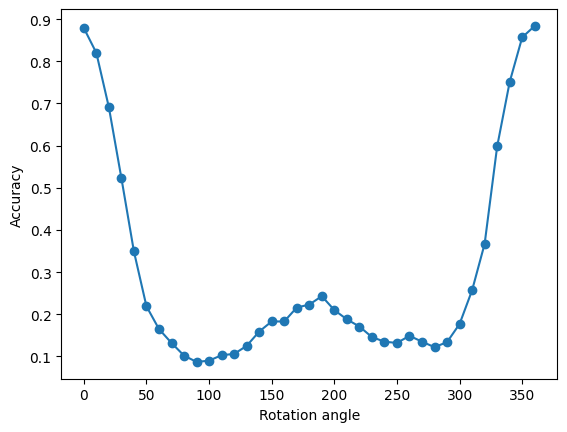

In [24]:
plt.plot(np.linspace(0,360,37),accuracies,"-o")
plt.xlabel("Rotation angle")
plt.ylabel("Accuracy")